In [1]:
# getting all of the stocks in the US
import os
from tenacity import retry, stop_after_attempt, wait_exponential
import requests
import pandas as pd
import investpy
import yfinance as yf
import pytz
from tqdm import tqdm
from datetime import datetime, timedelta

api_key = os.getenv('financial_modeling_prep_api_key')

In [2]:
# Get list of all stocks in the US
stocks = investpy.stocks.get_stocks(country='united states')
russel = pd.read_csv("russel1000.csv")
russel_tick = russel['Ticker'].to_list()


In [3]:
# Retry settings: 5 attempts with exponential backoff
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=10, max=60))
def fetch_json(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

In [4]:
# getting the dividend data for the above stocks
def get_dividend_data(tickers, api_key):
    """
    Fetches dividend data for a list of tickers using the Financial Modeling Prep API.
    Filters data to only include dividends from the last 5 years.
    Parameters:
    tickers (list): List of stock tickers.
    api_key (str): API key for Financial Modeling Prep.
    Returns:
    pd.DataFrame: DataFrame with columns 'Date', 'Ticker', 'Dividend', 'Adjusted Dividend', and 'Yield'.
    """
    
    # Get today's date and calculate 5 years ago
    today = datetime.now().date()
    five_years_ago = today - timedelta(days=5*365)
    
    all_dividends = []
    for ticker in tickers:
        #print(f"Fetching data for {ticker}")
        try:
            # Fetch dividend data using the provided API call
            dividend_data = fetch_json(f"https://financialmodelingprep.com/stable/dividends?symbol={ticker}&apikey={api_key}")
        except:
            print(f"Failed to fetch data for {ticker}")
            continue
        
        if not dividend_data:
            print(f"No dividend data for {ticker}")
            continue
        
        # Create a dataframe from the dividend data
        # Note: The API returns data from latest to earliest, so we keep this order
        df_data = []
        for dividend_record in dividend_data:
            dividend_date = datetime.strptime(dividend_record['date'], '%Y-%m-%d').date()
            # Only include dividends from the last 5 years
            if dividend_date >= five_years_ago:
                df_data.append({
                    'Date': dividend_record['date'],
                    'Ticker': ticker,
                    'Dividend': dividend_record['dividend'],
                    'Adjusted Dividend': dividend_record['adjDividend'],
                    'Yield': dividend_record['yield']
                })
        
        if df_data:
            df = pd.DataFrame(df_data)
            # Convert Date column to datetime
            df['Date'] = pd.to_datetime(df['Date'])
            all_dividends.append(df)
    
    if all_dividends:
        result = pd.concat(all_dividends, ignore_index=True)
        result.sort_values(by='Date', inplace=True)
        return result.reset_index(drop=True)
    else:
        print("No dividends found for any ticker.")
        return pd.DataFrame()
# Example usage:
#tickers = stocks['symbol'].to_list()
#df = get_dividend_data(russel_tick)

df = get_dividend_data(russel_tick, api_key)

No dividend data for AMZN
No dividend data for TSLA
No dividend data for BRKB
No dividend data for NFLX
No dividend data for PLTR
No dividend data for ISRG
No dividend data for NOW
No dividend data for UBER
No dividend data for BSX
No dividend data for APP
No dividend data for PANW
No dividend data for VRTX
No dividend data for ANET
No dividend data for CRWD
No dividend data for SPOT
No dividend data for CDNS
No dividend data for SNPS
No dividend data for PYPL
No dividend data for CMG
No dividend data for XTSLA
No dividend data for ORLY
No dividend data for DASH
No dividend data for FTNT
No dividend data for ABNB
No dividend data for SNOW
No dividend data for AZO
No dividend data for MSTR
No dividend data for COIN
No dividend data for WDAY
No dividend data for CPRT
No dividend data for NET
No dividend data for TEAM
No dividend data for AXON
No dividend data for XYZ
No dividend data for EW
No dividend data for HOOD
No dividend data for CBRE
No dividend data for NU
No dividend data for L

In [5]:
df.to_csv('Russel1000_dividend_last5years.csv')

# Filtering the stocks based on purchase criteria

In [19]:
df = pd.read_csv('Russel1000_dividend_last5years.csv')
df.dropna(inplace=True)
df.sort_values(by=['Ticker', 'Date'], ascending=True, inplace=True)
df.head()

,Unnamed: 0,Date,Ticker,Dividend,Adjusted Dividend,Yield
63,63,2020-06-29,A,0.180,0.180,0.806507
685,685,2020-10-05,A,0.180,0.180,0.698216
1287,1287,2021-01-04,A,0.194,0.194,0.618678
1900,1900,2021-04-05,A,0.194,0.194,0.575385
2529,2529,2021-07-02,A,0.194,0.194,0.512028


Find the yield for the last year

In [26]:
# Define the date range for filtering
start_date = "2024-06-12"
end_date = "2025-06-12"

# computing the last year dividend
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the last year
df_filtered = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Group by Ticker and sum Dividend Yield (%) for the last year
df_grouped = df_filtered.groupby("Ticker", as_index=False).mean(
    {"Yield": "sum"}
)

# Rename the column to "Last year Dividend Yield (%)"
df_grouped.rename(columns={"Yield": "Last year Yield"}, inplace=True)

# Merge back with the original df to retain all tickers
df_merged = df.merge(df_grouped[["Ticker", "Last year Yield"]], on="Ticker", how="left")

# Fill NaN with 0 for tickers with no dividends in the date range
df_merged["Last year Yield"] = df_merged["Last year Yield"].fillna(0)

In [28]:
df_merged.head()

,Unnamed: 0,Date,Ticker,Dividend,Adjusted Dividend,Yield,Last year Yield
0,63,2020-06-29,A,0.180,0.180,0.806507,0.736563
1,685,2020-10-05,A,0.180,0.180,0.698216,0.736563
2,1287,2021-01-04,A,0.194,0.194,0.618678,0.736563
3,1900,2021-04-05,A,0.194,0.194,0.575385,0.736563
4,2529,2021-07-02,A,0.194,0.194,0.512028,0.736563


# Find a list of stocks with higher than desired yield

In [52]:
desired_yield = 5
#print(df_merged[df_merged["Last year Yield"]>desired_yield]["Last year Yield"].mean())
list_of_high_yield_from_last_year = df_merged[df_merged["Last year Yield"]>desired_yield]['Ticker'].unique().tolist()
filtered_list_of_high_yields = []

# making sure that this security has been paying quarterly dividends for the past 5 years
start_date = "2020-06-12"
end_date = "2025-06-12"
num_expected_dividends = 19 # 4 quarters per year for 5 years

for ticker in list_of_high_yield_from_last_year:
    mask = (
        (df_merged["Ticker"] == ticker) &
        (df_merged["Date"] >= start_date) &
        (df_merged["Date"] <= end_date)
    )
    
    current = df_merged.loc[mask]          # no warning
    if len(current) < num_expected_dividends:
        continue
    if current['Yield'].mean() < 2:
        continue
    filtered_list_of_high_yields.append(ticker)
print(filtered_list_of_high_yields)

['AES', 'AFG', 'AGNC', 'AM', 'BEN', 'BXP', 'CAG', 'CC', 'CCI', 'CHRD', 'CMA', 'CNA', 'COLB', 'CWEN', 'DDS', 'DOC', 'DOW', 'EPR', 'GLPI', 'HIW', 'HR', 'KHC', 'KRC', 'LEG', 'LNC', 'LYB', 'MO', 'MPW', 'NLY', 'NNN', 'NSA', 'O', 'OHI', 'OMF', 'ORI', 'PFE', 'PII', 'RITM', 'RLI', 'STWD', 'T', 'TFSL', 'UGI', 'UPS', 'VICI', 'VNOM', 'VZ', 'WEN', 'WHR', 'WPC', 'WU']


# Compute and plot the collective portfolio return

Fetching data for 51 stocks over 3 years...
AES: -19.79%
AFG: 35.52%
AGNC: 97.47%
AM: 162.75%
BEN: 30.59%
BXP: 10.49%
CAG: -7.56%
CC: -57.29%
CCI: -12.15%
CHRD: 28.61%
CMA: 0.41%
CNA: 64.54%
COLB: 12.09%
CWEN: 33.14%
DDS: 85.28%
DOC: 5.43%
DOW: -21.98%
EPR: 92.44%
GLPI: 54.14%
HIW: 40.09%
HR: -7.11%
KHC: -1.73%
KRC: 0.56%
LEG: -56.32%
LNC: -6.22%
LYB: -7.63%
MO: 94.29%
MPW: -40.01%
NLY: 79.12%
NNN: 45.80%
NSA: 4.83%
O: 24.99%
OHI: 108.46%
OMF: 125.47%
ORI: 141.24%
PFE: -28.05%
PII: -46.79%
RITM: 114.93%
RLI: 40.71%
STWD: 69.29%
T: 93.88%
TFSL: 53.58%
UGI: 18.49%
UPS: -21.71%
VICI: 53.88%
VNOM: 79.04%
VZ: 26.36%
WEN: -9.51%
WHR: -14.01%
WPC: 12.90%
WU: -12.51%


/tmp/ipykernel_1831/946933799.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.fillna(method='ffill').fillna(method='bfill')


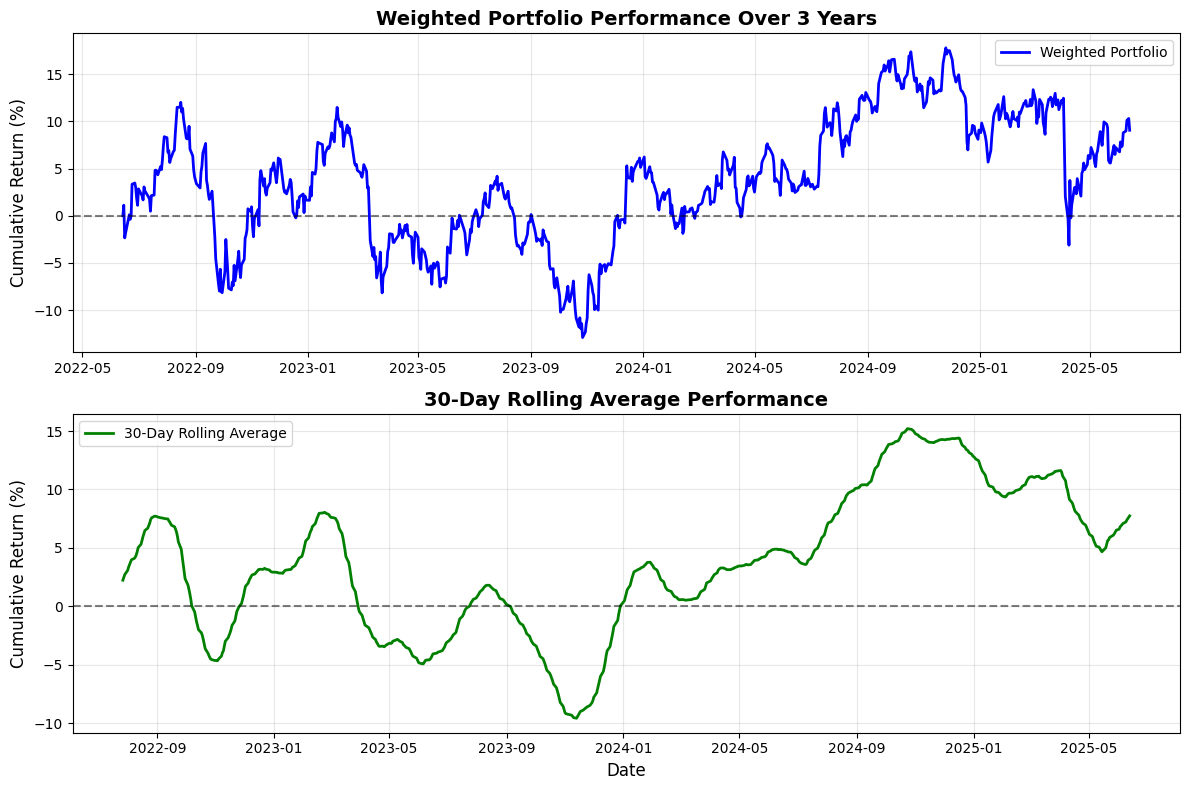


PORTFOLIO PERFORMANCE SUMMARY (3 YEARS)
Total Portfolio Return: 30.79%
Annualized Return: 10.26%
Valid Stocks: 51/51
Average Individual Return: 30.79%
Best Individual Performer: 162.75%
Worst Individual Performer: -57.29%
Peak Portfolio Return: 17.79%
Lowest Portfolio Return: -12.91%
Final Portfolio Return: 9.06%


In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def calculate_weighted_portfolio_return(stock_list, weights, years, plot_results=True):
    """
    Calculate the collective return of a weighted portfolio over the past y years.
    
    Parameters:
    stock_list (list): List of stock tickers
    weights (list): List of weights corresponding to each stock (should sum to 1.0)
    years (int): Number of years to look back
    plot_results (bool): Whether to plot the portfolio performance over time
    
    Returns:
    dict: Dictionary containing portfolio return, individual stock returns, summary stats, and time series data
    """
    
    # Check if stock list and weights list are the same size
    if len(stock_list) != len(weights):
        raise ValueError(f"Stock list length ({len(stock_list)}) does not match weights length ({len(weights)})")
    
    # Check if weights sum to approximately 1.0
    weights_sum = sum(weights)
    if abs(weights_sum - 1.0) > 0.001:
        print(f"Warning: Weights sum to {weights_sum:.4f}, not 1.0. Normalizing weights.")
        weights = [w / weights_sum for w in weights]
    
    # Fetch historical data for all stocks
    stock_data = {}
    individual_returns = {}
    price_data = pd.DataFrame()
    
    print(f"Fetching data for {len(stock_list)} stocks over {years} years...")
    
    for ticker in stock_list:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period=f"{years}y")
            
            if hist.empty:
                print(f"Warning: No data available for {ticker}")
                individual_returns[ticker] = 0.0
                continue
            
            # Store price data for time series analysis
            price_data[ticker] = hist['Close']
            
            # Calculate total return (including dividends if available)
            start_price = hist['Close'].iloc[0]
            end_price = hist['Close'].iloc[-1]
            
            # Get dividend data
            try:
                dividends = stock.dividends
                # Filter dividends for the period
                period_start = hist.index[0]
                period_dividends = dividends[dividends.index >= period_start]
                total_dividends = period_dividends.sum()
            except:
                total_dividends = 0.0
            
            # Calculate total return
            total_return = ((end_price + total_dividends) - start_price) / start_price
            individual_returns[ticker] = total_return
            
            print(f"{ticker}: {total_return:.2%}")
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            individual_returns[ticker] = 0.0
    
    # Calculate weighted portfolio performance over time
    portfolio_time_series = None
    
    if not price_data.empty:
        # Fill missing values and align dates
        price_data = price_data.fillna(method='ffill').fillna(method='bfill')
        
        # Calculate daily returns for each stock
        returns_data = price_data.pct_change().fillna(0)
        
        # Calculate weighted portfolio returns
        portfolio_returns = pd.Series(0.0, index=returns_data.index)
        
        for i, ticker in enumerate(stock_list):
            if ticker in returns_data.columns:
                portfolio_returns += weights[i] * returns_data[ticker]
        
        # Calculate cumulative portfolio performance
        portfolio_time_series = (1 + portfolio_returns).cumprod()
        
        # Convert to percentage returns from initial investment
        portfolio_time_series = (portfolio_time_series - 1) * 100
    
    # Calculate weighted portfolio return
    portfolio_return = 0.0
    valid_stocks = 0
    
    for i, ticker in enumerate(stock_list):
        if ticker in individual_returns:
            portfolio_return += weights[i] * individual_returns[ticker]
            valid_stocks += 1
    
    # Summary statistics
    valid_returns = [ret for ret in individual_returns.values() if ret != 0.0]
    
    results = {
        'portfolio_return': portfolio_return,
        'portfolio_return_pct': portfolio_return * 100,
        'individual_returns': individual_returns,
        'valid_stocks': valid_stocks,
        'total_stocks': len(stock_list),
        'avg_individual_return': np.mean(valid_returns) if valid_returns else 0.0,
        'min_return': min(valid_returns) if valid_returns else 0.0,
        'max_return': max(valid_returns) if valid_returns else 0.0,
        'weights_used': weights,
        'portfolio_time_series': portfolio_time_series
    }
    
    # Plot results if requested
    if plot_results and portfolio_time_series is not None:
        plt.figure(figsize=(12, 8))
        
        # Main portfolio performance plot
        plt.subplot(2, 1, 1)
        plt.plot(portfolio_time_series.index, portfolio_time_series.values, 
                linewidth=2, color='blue', label='Weighted Portfolio')
        plt.title(f'Weighted Portfolio Performance Over {years} Years', fontsize=14, fontweight='bold')
        plt.ylabel('Cumulative Return (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add horizontal line at 0%
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Rolling 30-day average
        plt.subplot(2, 1, 2)
        rolling_30d = portfolio_time_series.rolling(window=30).mean()
        plt.plot(portfolio_time_series.index, rolling_30d.values, 
                linewidth=2, color='green', label='30-Day Rolling Average')
        plt.title('30-Day Rolling Average Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Cumulative Return (%)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*50}")
        print(f"PORTFOLIO PERFORMANCE SUMMARY ({years} YEARS)")
        print(f"{'='*50}")
        print(f"Total Portfolio Return: {results['portfolio_return_pct']:.2f}%")
        print(f"Annualized Return: {(results['portfolio_return_pct']/years):.2f}%")
        print(f"Valid Stocks: {results['valid_stocks']}/{results['total_stocks']}")
        print(f"Average Individual Return: {results['avg_individual_return']:.2%}")
        print(f"Best Individual Performer: {results['max_return']:.2%}")
        print(f"Worst Individual Performer: {results['min_return']:.2%}")
        
        if portfolio_time_series is not None:
            max_return = portfolio_time_series.max()
            min_return = portfolio_time_series.min()
            final_return = portfolio_time_series.iloc[-1]
            print(f"Peak Portfolio Return: {max_return:.2f}%")
            print(f"Lowest Portfolio Return: {min_return:.2f}%")
            print(f"Final Portfolio Return: {final_return:.2f}%")
    
    return results

# Example with equal weights
equal_weights = [1/len(filtered_list_of_high_yields)] * len(filtered_list_of_high_yields)

# Calculate and plot returns for the past 3 years
results = calculate_weighted_portfolio_return(filtered_list_of_high_yields, equal_weights, 3, plot_results=True)

# Plot and observe individual dividend trends

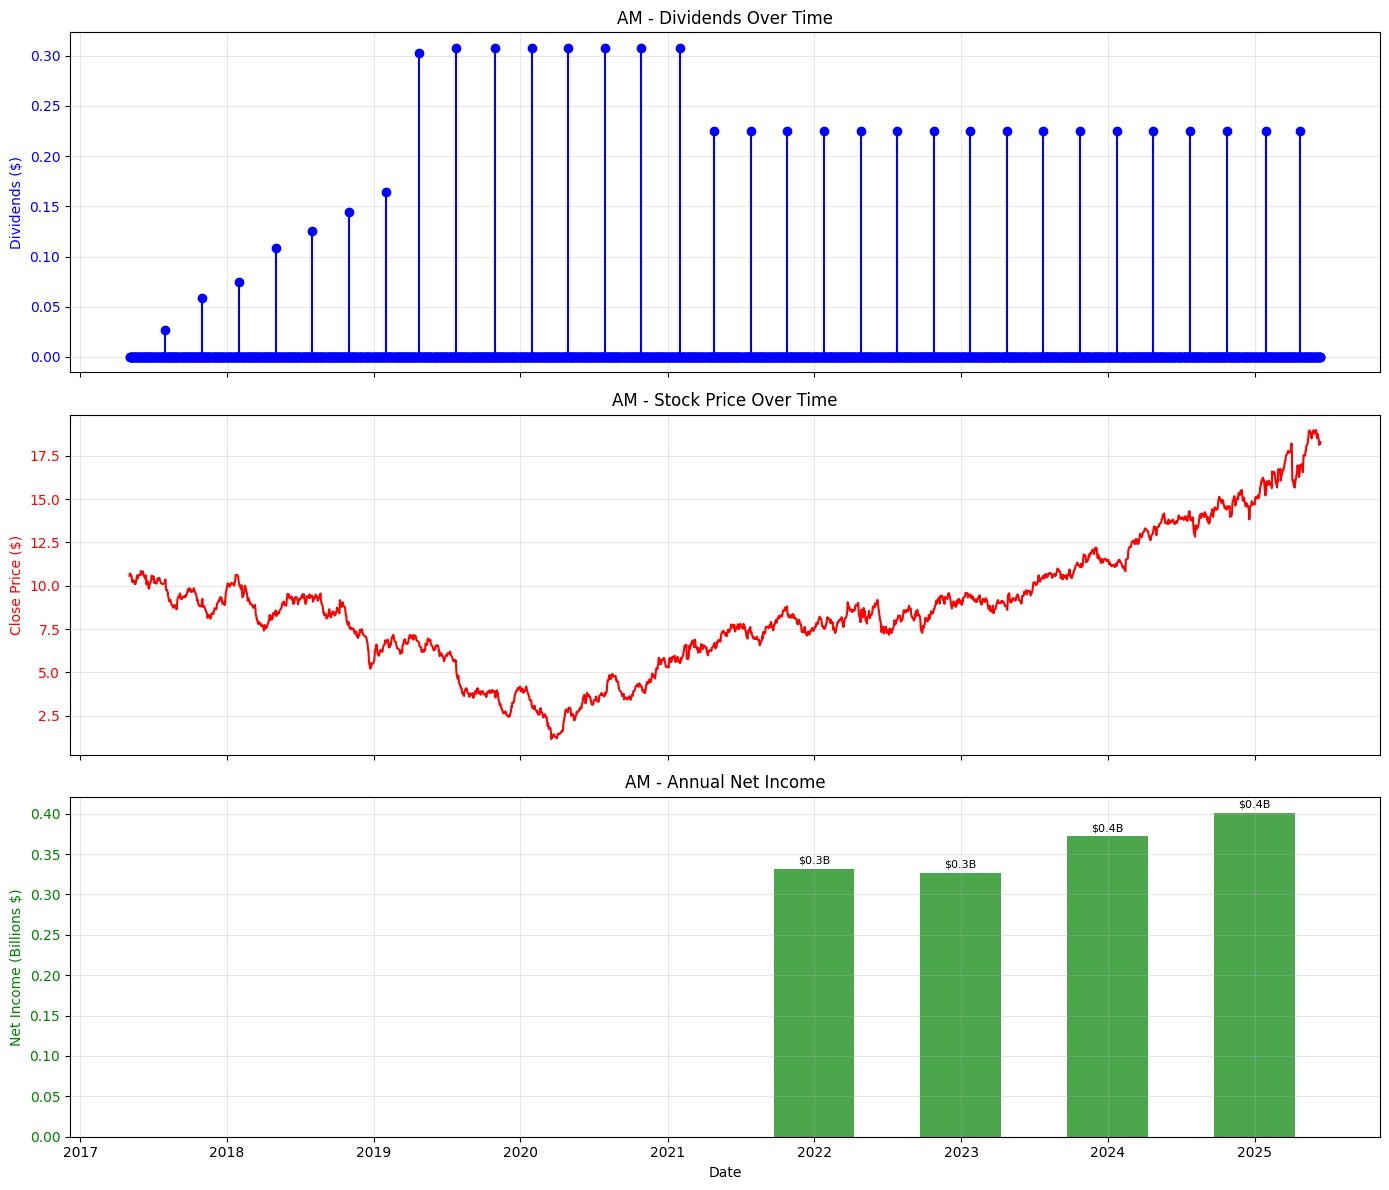


=== AM Summary Statistics ===
Dividend Stats:
  Total Dividends Paid: 6.99
  Average Dividend: 0.22
  Latest Dividend: 0.23

Price Stats:
  Current Price: $18.28
  52-Week High: $18.99
  52-Week Low: $1.15

Net Income Stats:
  Latest Net Income: $nanB
  Average Net Income: $0.4B


In [56]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = filtered_list_of_high_yields[3]

# Initialize DataFrames to store data
all_dividends = pd.DataFrame()
all_prices = pd.DataFrame()
stock = yf.Ticker(ticker)

# Get dividend history
dividends = stock.dividends.reset_index()
dividends['Ticker'] = ticker

# Get historical price data
prices = stock.history(period="max").reset_index()[['Date', 'Close']]
prices['Ticker'] = ticker

# Get financial data (includes net income)
try:
    # Get annual financials
    financials = stock.financials
    # Net income is typically in the first row
    net_income = financials.loc['Net Income'] if 'Net Income' in financials.index else None
    
    # If Net Income not found, try alternative names
    if net_income is None:
        for possible_name in ['Total Revenue', 'Revenue', 'Net Income Common Stockholders']:
            if possible_name in financials.index:
                net_income = financials.loc[possible_name]
                break
    
    if net_income is not None:
        # Convert to DataFrame and reset index
        net_income_df = net_income.reset_index()
        net_income_df.columns = ['Date', 'Net_Income']
        net_income_df['Net_Income'] = net_income_df['Net_Income'] / 1e9  # Convert to billions
        net_income_df.set_index('Date', inplace=True)
    else:
        net_income_df = pd.DataFrame()
        
except Exception as e:
    print(f"Warning: Could not fetch financial data: {e}")
    net_income_df = pd.DataFrame()

# Append to the main DataFrames
all_dividends = pd.concat([all_dividends, dividends], ignore_index=True)
all_prices = pd.concat([all_prices, prices], ignore_index=True)

# Set the date as the index
all_dividends.set_index('Date', inplace=True)
all_prices.set_index('Date', inplace=True)

div_data = all_dividends[all_dividends['Ticker'] == ticker]
price_data = all_prices[all_prices['Ticker'] == ticker]

# Aligning the indices to ensure proper plotting
combined_data = pd.merge(price_data, div_data[['Dividends']], left_index=True, right_index=True, how='outer')

# Create the plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Dividends
ax1.stem(combined_data.index, combined_data['Dividends'].fillna(0), 
         linefmt='blue', markerfmt='bo', basefmt=" ", label='Dividends')
ax1.set_ylabel('Dividends ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{ticker} - Dividends Over Time')
ax1.grid(True, alpha=0.3)

# Plot 2: Stock Price
ax2.plot(combined_data.index, combined_data['Close'], color='red', linewidth=1.5, label='Close Price')
ax2.set_ylabel('Close Price ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title(f'{ticker} - Stock Price Over Time')
ax2.grid(True, alpha=0.3)

# Plot 3: Net Income (if available)
if not net_income_df.empty:
    ax3.bar(net_income_df.index, net_income_df['Net_Income'], 
            color='green', alpha=0.7, width=200, label='Net Income')
    ax3.set_ylabel('Net Income (Billions $)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.set_title(f'{ticker} - Annual Net Income')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for date, value in zip(net_income_df.index, net_income_df['Net_Income']):
        ax3.text(date, value + (max(net_income_df['Net_Income']) * 0.01), 
                f'${value:.1f}B', ha='center', va='bottom', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'Net Income data not available', 
             transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    ax3.set_title(f'{ticker} - Net Income (Data Not Available)')

ax3.set_xlabel('Date')

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== {ticker} Summary Statistics ===")
print(f"Dividend Stats:")
print(f"  Total Dividends Paid: {div_data['Dividends'].sum():.2f}")
print(f"  Average Dividend: {div_data['Dividends'].mean():.2f}")
print(f"  Latest Dividend: {div_data['Dividends'].iloc[-1]:.2f}" if not div_data.empty else "  No dividend data")

print(f"\nPrice Stats:")
print(f"  Current Price: ${price_data['Close'].iloc[-1]:.2f}" if not price_data.empty else "  No price data")
print(f"  52-Week High: ${price_data['Close'].max():.2f}" if not price_data.empty else "")
print(f"  52-Week Low: ${price_data['Close'].min():.2f}" if not price_data.empty else "")

if not net_income_df.empty:
    print(f"\nNet Income Stats:")
    print(f"  Latest Net Income: ${net_income_df['Net_Income'].iloc[-1]:.1f}B")
    print(f"  Average Net Income: ${net_income_df['Net_Income'].mean():.1f}B")